## Ativida 2 LSTM



In [49]:
pip install pandas yfinance scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [67]:
import yfinance as yf
import numpy as np


# Baixar dados para um ativo específico
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
print(data.head())

# Dividir dados em treinamento e validação
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.478997  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.490199  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.386965  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.375156  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.417541  447610800


In [51]:
def prepare_data(data, n_steps):
    X, y = [], []  # Inicializa listas vazias para armazenar as sequências de entrada (X) e saída (y)
    for i in range(len(data)-n_steps):
        X.append(data[i:(i+n_steps)])  # Adiciona uma sequência de tamanho n_steps à lista X
        y.append(data[i+n_steps])  # Adiciona o próximo valor como a saída correspondente à lista y
    return np.array(X), np.array(y)  # Converte as listas para arrays numpy e retorna X e y


n_steps = 10  # Defina o número de passos temporais desejados
X_train, y_train = prepare_data(train['Close'].values, n_steps)
X_val, y_val = prepare_data(validation['Close'].values, n_steps)

# Preparar dados para a LSTM Sequence-to-Sequence
# def prepare_data_seq2seq(data, n_steps_in, n_steps_out):
#     X, y = [], []
#     for i in range(len(data)-(n_steps_in+n_steps_out)+1):
#         X.append(data[i:(i+n_steps_in)])
#         y.append(data[(i+n_steps_in):(i+n_steps_in+n_steps_out)])
#     return np.array(X), np.array(y)

# n_steps_in = 10  # Número de passos temporais na entrada
# n_steps_out = 5  # Número de passos temporais na saída

# X_train, y_train = prepare_data_seq2seq(train['Close'].values, n_steps_in, n_steps_out)
# X_val, y_val = prepare_data_seq2seq(validation['Close'].values, n_steps_in, n_steps_out)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defina o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))  # 1 feature (Close price)
model.add(Dense(1))  # Saída única para a predição do valor
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error como função de perda

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
# from tensorflow.keras.optimizers import Adam

# # Definir o modelo LSTM Sequence-to-Sequence
# model = Sequential()
# model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
# model.add(RepeatVector(n_steps_out))
# model.add(LSTM(units=50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))  # Saída para cada passo temporal
# # model.compile(optimizer='adam', loss='mse')  # Mean Squared Error como função de perda

# optimizer = Adam(learning_rate=0.001)  # Experimente diferentes valores de lr
# model.compile(optimizer=optimizer, loss='mse')


In [53]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
82/82 [==============================] - 1s 6ms/step - loss: 102.7678 - val_loss: 148.7435
Epoch 2/50
82/82 [==============================] - 0s 4ms/step - loss: 1.8221 - val_loss: 1277.3123
Epoch 3/50
82/82 [==============================] - 0s 4ms/step - loss: 1.4104 - val_loss: 715.7374
Epoch 4/50
82/82 [==============================] - 0s 4ms/step - loss: 1.3052 - val_loss: 261.8625
Epoch 5/50
82/82 [==============================] - 0s 4ms/step - loss: 1.0276 - val_loss: 293.5699
Epoch 6/50
82/82 [==============================] - 0s 4ms/step - loss: 0.9220 - val_loss: 42.1819
Epoch 7/50
82/82 [==============================] - 0s 4ms/step - loss: 0.9685 - val_loss: 18.4591
Epoch 8/50
82/82 [==============================] - 0s 4ms/step - loss: 0.7497 - val_loss: 47.2467
Epoch 9/50
82/82 [==============================] - 0s 4ms/step - loss: 0.8018 - val_loss: 25.3807
Epoch 10/50
82/82 [==============================] - 0s 4ms/step - loss: 0.7171 - val_loss: 19.2026
E

In [54]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(mse)

21/21 [==============================] - 0s 2ms/step
63.706060826724354


In [66]:
baseline = validation['Close'].shift(n_steps).values[n_steps:]  # Usando o valor anterior como baseline
baseline_mse = mean_squared_error(y_val, baseline)
print(mse)
print(baseline_mse)


63.706060826724354
71.0937161234952


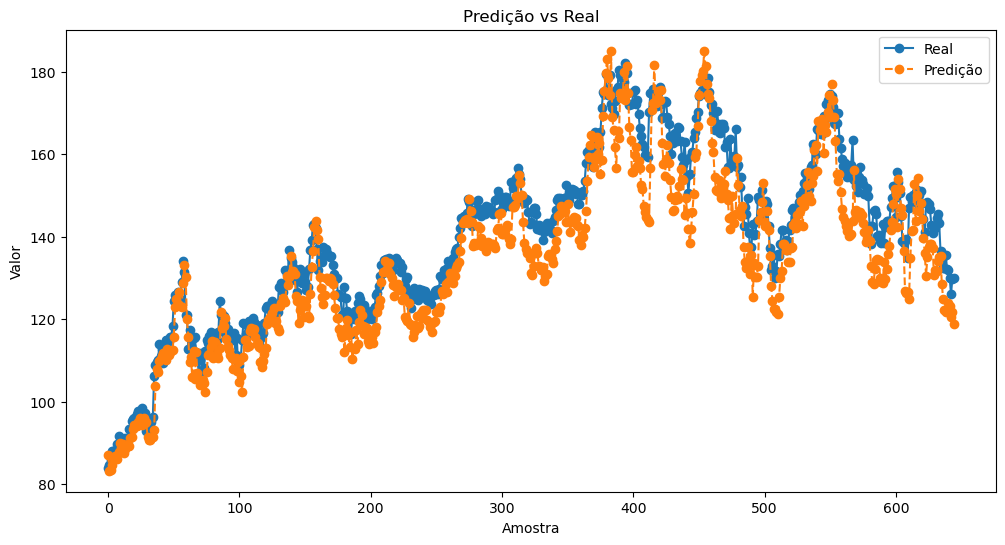

In [56]:
import matplotlib.pyplot as plt

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Real', marker='o')
plt.plot(predictions, label='Predição', linestyle='dashed', marker='o')
plt.title('Predição vs Real')
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.legend()
plt.show()

21/21 [==============================] - 0s 2ms/step


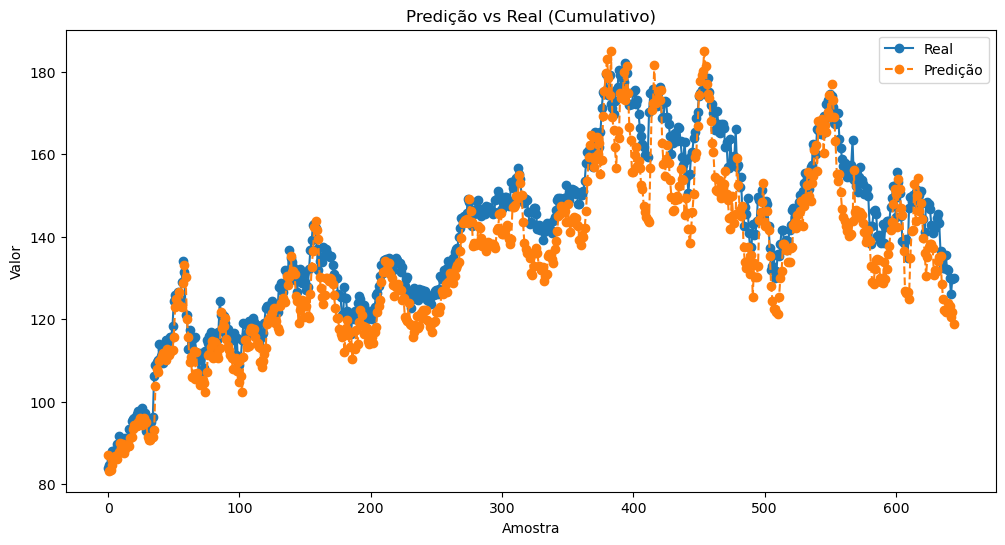

In [64]:
def prepare_data_cumulative(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])  # Adiciona uma sequência de tamanho n_steps à lista X
        y.append(data[i])             # Adiciona o próximo valor como a saída correspondente à lista y
    return np.array(X), np.array(y)

n_steps = 10  # Defina o número de passos temporais desejados
X_train_cumulative, y_train_cumulative = prepare_data_cumulative(train['Close'].values, n_steps)
X_val_cumulative, y_val_cumulative = prepare_data_cumulative(validation['Close'].values, n_steps)

# Realizar predições no conjunto de validação
predictions_cumulative = model.predict(X_val_cumulative)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_val_cumulative, label='Real', marker='o')
plt.plot(predictions_cumulative, label='Predição', linestyle='dashed', marker='o')
plt.title('Predição vs Real (Cumulativo)')
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.legend()
plt.show()



In [65]:
predictions_cumulative = model.predict(X_val_cumulative)
mseC = mean_squared_error(y_val_cumulative, predictions_cumulative)
print(mseC)

21/21 [==============================] - 0s 1ms/step
63.706060826724354
